- **BPE代码流程：**
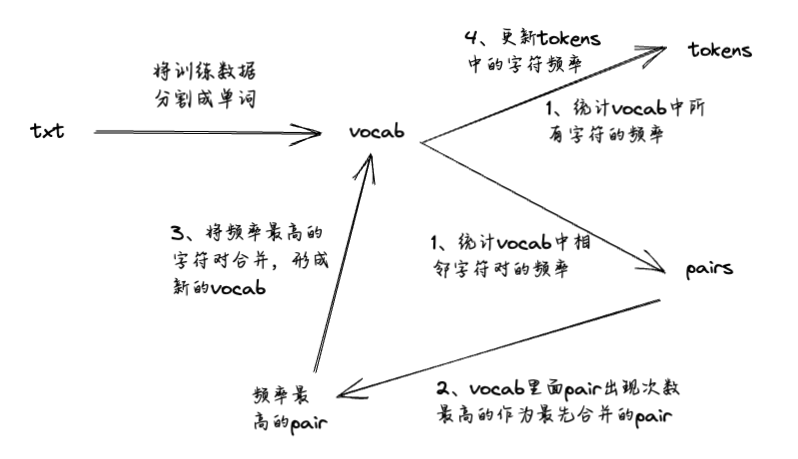

In [3]:
import re, collections

# 所有训练数据
text = """
The aims for this subject is for students to develop an understanding of the main 
algorithms used in naturallanguage processing, for use in a diverse range of applications 
including text classification, machine translation, and question answering. Topics to be 
covered include part-of-speech tagging, n-gram language modelling, syntactic parsing and 
deep learning. The programming language used is Python, see for more information on its 
use in the workshops, assignments and installation at home.
"""


# 将所有训练数据分割成单词
def get_vocab(text):
    
    # 初始化为 0
    vocab = collections.defaultdict(int)
    for word in text.strip().split():      # 去头去尾，再用空格分词
        #使用</w>作为词的结尾
        # 给list中每个元素增加空格，并在最后增加结束符号</w>，同时统计单词出现次数
        vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab
print(get_vocab(text))


defaultdict(<class 'int'>, {'T h e </w>': 2, 'a i m s </w>': 1, 'f o r </w>': 4, 't h i s </w>': 1, 's u b j e c t </w>': 1, 'i s </w>': 2, 's t u d e n t s </w>': 1, 't o </w>': 2, 'd e v e l o p </w>': 1, 'a n </w>': 1, 'u n d e r s t a n d i n g </w>': 1, 'o f </w>': 2, 't h e </w>': 2, 'm a i n </w>': 1, 'a l g o r i t h m s </w>': 1, 'u s e d </w>': 2, 'i n </w>': 3, 'n a t u r a l l a n g u a g e </w>': 1, 'p r o c e s s i n g , </w>': 1, 'u s e </w>': 2, 'a </w>': 1, 'd i v e r s e </w>': 1, 'r a n g e </w>': 1, 'a p p l i c a t i o n s </w>': 1, 'i n c l u d i n g </w>': 1, 't e x t </w>': 1, 'c l a s s i f i c a t i o n , </w>': 1, 'm a c h i n e </w>': 1, 't r a n s l a t i o n , </w>': 1, 'a n d </w>': 3, 'q u e s t i o n </w>': 1, 'a n s w e r i n g . </w>': 1, 'T o p i c s </w>': 1, 'b e </w>': 1, 'c o v e r e d </w>': 1, 'i n c l u d e </w>': 1, 'p a r t - o f - s p e e c h </w>': 1, 't a g g i n g , </w>': 1, 'n - g r a m </w>': 1, 'l a n g u a g e </w>': 2, 'm o d e l l

In [4]:
"""
这个函数遍历词汇表中的所有单词，并计算彼此相邻的一对标记。

EXAMPLE:
    word = 'T h e <\w>'
    这个单词可以两两组合成： [('T', 'h'), ('h', 'e'), ('e', '<\w>')]
    
输入:
    vocab: Dict[str, int]  # vocab统计了词语出现的词频
    
输出:
    pairs: Dict[Tuple[str, str], int] # 字母对，pairs统计了单词对出现的频率
"""
def get_stats(vocab):
    pairs = collections.defaultdict(int)
    
    for word,freq in vocab.items():
        # 遍历每一个word里面的symbol，去凑所有的相邻两个内容
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[(symbols[i],symbols[i+1])] += freq

    return pairs


In [11]:
"""
EXAMPLE:
    word = 'T h e <\w>'
    pair = ('e', '<\w>')
    word_after_merge = 'T h e<\w>'
    
输入:
    pair: Tuple[str, str] # 需要合并的字符对
    v_in: Dict[str, int]  # 合并前的vocab
    
输出:
    v_out: Dict[str, int] # 合并后的vocab
    
注意:
    当合并word 'Th e<\w>'中的字符对 ('h', 'e')时，'Th'和'e<\w>'字符对不能被合并。
"""
def merge_vocab(pair, v_in):
    v_out = {}
    # 把pair拆开，然后用空格合并起来，然后用\把空格转义
    bigram = re.escape(' '.join(pair))
    # 自定义一个正则规则, (?<!\S)h\ e(?!\S) 只有前面、后面不是非空白字符(\S)(意思前后得是没东西的)，才匹配h\ e，这样就可以把Th\ e<\w>排除在外
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    
    for v in v_in:
        # 遍历当前的vocabulary，找到匹配正则的v时，才用合并的pair去替换变成新的pair new，如果没有匹配上，那就保持原来的。
        # 比如pair当前是'h'和'e'，然后遍历vocabulary，找到符合前后都没有东西只有'h\ e'的时候就把他们并在一起变成'he'
        new = p.sub(''.join(pair),v)
        # 然后新的合并的数量就是当前vocabulary里面pair对应的数量
        v_out[new] = v_in[v]
    return v_out

def get_tokens(vocab):
    tokens = collections.defaultdict(int)
    for word, freq in vocab.items():
        word_tokens = word.split()
        for token in word_tokens:
            tokens[token] += freq
    return tokens


print('==========')
vocab = get_vocab(text)
tokens = get_tokens(vocab)
print("Vocab =", vocab)
print('Tokens: {}'.format(tokens))
print('Number of tokens: {}'.format(len(tokens)), end="\n\n\n")


#about 100 merges we start to see common words
num_merges = 100
for i in range(num_merges):
    pairs = get_stats(vocab)  #统计vocab中相邻字符对的频率
    if not pairs:
        break
    
    best = max(pairs, key=pairs.get)  #vocab里面pair出现次数最高的作为最先合并的pair
    new_token = ''.join(best)
    vocab = merge_vocab(best, vocab)  #将频率最高的字符对合并，形成新的vocab
    
    # 更新tokens中的字符频率
    tokens[new_token] = pairs[best]
    tokens[best[0]] -= pairs[best]
    tokens[best[1]] -= pairs[best]
    
    print('========== Iter: {}'.format(i))
    print('Best pair: {}'.format(best))
    print('Number of tokens: {}\n'.format(len(tokens)))

print("vocab:", vocab)
print("tokens:", tokens)

Vocab = defaultdict(<class 'int'>, {'T h e </w>': 2, 'a i m s </w>': 1, 'f o r </w>': 4, 't h i s </w>': 1, 's u b j e c t </w>': 1, 'i s </w>': 2, 's t u d e n t s </w>': 1, 't o </w>': 2, 'd e v e l o p </w>': 1, 'a n </w>': 1, 'u n d e r s t a n d i n g </w>': 1, 'o f </w>': 2, 't h e </w>': 2, 'm a i n </w>': 1, 'a l g o r i t h m s </w>': 1, 'u s e d </w>': 2, 'i n </w>': 3, 'n a t u r a l l a n g u a g e </w>': 1, 'p r o c e s s i n g , </w>': 1, 'u s e </w>': 2, 'a </w>': 1, 'd i v e r s e </w>': 1, 'r a n g e </w>': 1, 'a p p l i c a t i o n s </w>': 1, 'i n c l u d i n g </w>': 1, 't e x t </w>': 1, 'c l a s s i f i c a t i o n , </w>': 1, 'm a c h i n e </w>': 1, 't r a n s l a t i o n , </w>': 1, 'a n d </w>': 3, 'q u e s t i o n </w>': 1, 'a n s w e r i n g . </w>': 1, 'T o p i c s </w>': 1, 'b e </w>': 1, 'c o v e r e d </w>': 1, 'i n c l u d e </w>': 1, 'p a r t - o f - s p e e c h </w>': 1, 't a g g i n g , </w>': 1, 'n - g r a m </w>': 1, 'l a n g u a g e </w>': 2, 'm o